# Financial Derivatives and Risk Management
## Individual Assignment (2024)
### Author: Luís Filipe Ribeiro (20231536)

----------------------------------------

## 1) Select a stock or index with liquid options in the 1 to 3 month range. Name your stock/index.

### a) Pick a expiration timeframe T to consider in this range

In [2]:
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

#For this assignment, I chose Coca-Cola stock for a maturity/tenor of T=3/12 (expiring 3 mo.)
symbol = 'KO'
ticker = yf.Ticker(symbol)

#useful
date_format = '%Y-%m-%d'
today_date = datetime.now()


closest_date = min(
    map(lambda dt: datetime.strptime(dt, date_format), ticker.options), 
    key=lambda dt_obj: abs(dt_obj - (today_date + timedelta(days=90)))
)

#Determine actual tenor of option (close to 3/12), but we need it for better pricing
N = (closest_date - datetime.strptime(today_date.strftime(date_format), date_format)).days
T = N / 360

#convert from date time to string
closest_date_dt_obj = closest_date
closest_date = closest_date.strftime(date_format)

print("Closest option date: ", closest_date)
print("Actual T value:", T)
print("Actual number of outstanding days (tenor):", N)

Closest option date:  2024-09-20
Actual T value: 0.24722222222222223
Actual number of outstanding days (tenor): 89


### b) Pick the strike price available closest to current price

In [3]:
#Because the assignment does not specify, I assume it's a call option
#So first step is listing all strike prices expiring 3 mo. from current date
option_chain = ticker.option_chain(closest_date)

calls = option_chain.calls
puts = option_chain.puts

calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,KO240920C00047500,2024-05-13 13:42:05+00:00,47.5,16.27,15.50,15.65,0.0,0.0,1,1,0.396490,True,REGULAR,USD
1,KO240920C00050000,2024-06-13 19:03:45+00:00,50.0,13.12,11.60,15.50,0.0,0.0,5,11,0.671390,True,REGULAR,USD
2,KO240920C00052500,2024-06-20 14:27:26+00:00,52.5,10.88,9.00,13.05,0.0,0.0,1,144,0.590336,True,REGULAR,USD
3,KO240920C00055000,2024-06-14 15:44:56+00:00,55.0,8.31,7.10,10.65,0.0,0.0,1,146,0.514653,True,REGULAR,USD
4,KO240920C00057500,2024-06-20 13:59:17+00:00,57.5,5.90,6.15,6.35,0.0,0.0,1,130,0.252815,True,REGULAR,USD


In [4]:
#Second step is getting closest call option to current price
S0 = ticker.info['currentPrice']
print("Current price:", S0)

#Determine closest call & put
closest_call = calls.iloc[(calls['strike'] - S0).abs().argmin()]
closest_put = puts.iloc[(puts['strike'] - S0).abs().argmin()]

#This has to be true to continue...
assert closest_call.strike == closest_put.strike

#print("\nClosest call option:", closest_call)
K = closest_call.strike
print("\nClosest strike price:", K)

Current price: 62.77

Closest strike price: 62.5


### c) Determine the risk free rate you will apply and find the value

The risk free rate should be the rate that is expected for money applications/deposits for the duration of the investment. Since we're dealing with an option expiring in 3 mo., the rate should be the risk free rate for a 3 mo. investment.

The closest we can essentially get to a risk free investment is a US Treasury obligation/bond for that duration of time. So the rate will be the US T-Bill for 3 mo.

There is a really simple way to get the US 3 mo. T-Bill yield using Yahoo Finance. We can simply look up the IRX index is which is the 13 week US T-Bill rate: https://finance.yahoo.com/quote/%5EIRX/

In [5]:
def get_3mo_risk_free_rate():
    rate = yf.Ticker('^IRX') \
        .history(period="1d") \
        .Close \
        .iloc[-1]
    return rate / 100

rf = get_3mo_risk_free_rate()
print("Risk free rate = ", rf)

Risk free rate =  0.052150001525878904


### d) Estimate volatility for the calculation of option prices

For estimatine the volatility of the option, we can determine the annualized standard deviation of the last 3 months of daily returns.

In other words: sigma_3mo = std_dev(daily_returns_last_3mo) * sqrt(252)

In [6]:
#Determine the volatility of last 3 months daily log returns
sigma = ticker.history(period="3mo") \
    .pct_change() \
    .Close \
    .apply(lambda r: np.log(r+1)) \
    .std()

#Annualize it
sigma *= np.sqrt(252)

print("Sigma/Volatility: ", sigma)

Sigma/Volatility:  0.11054128132910053


### e) Consider if you will include a dividend yield and estimate if so

The chosen company, Coca-Cola, is a well known for dividend paying. Therefore, I will include a dividend yield estimate.

The easy way to do it is using the put-call parity:
$$ c + Ke^{-rT} = p + S_0e^{-qT}$$
So it follows that:
$$ \frac{ -ln( \frac{c + Ke^{-rT} - p}{S_0} ) }{T} = q $$

In [7]:
def get_dividend_yield(S, c, p, K, r, T):
    log_arg = (c + K * np.exp(-r * T) - p)/S
    return -np.log(log_arg)/T
    
q = get_dividend_yield(S=S0, c=closest_call.lastPrice, p=closest_put.lastPrice, K=K, r=rf, T=T)
print("Dividend yield:", q)

Dividend yield: 0.014888545239218665


Alternatively we could find a root finder...

In [8]:
from scipy.optimize import fsolve

def dividend_yield_root_func(q):
    lhs = closest_call.lastPrice + K * np.exp(-rf * T)
    rhs = closest_put.lastPrice + S0 * np.exp(-q * T)
    return lhs - rhs

fsolve(dividend_yield_root_func, 0.01)[0]

0.014888545239218483

## 2) Estimate European Call and Put option prices using your previously decided values with the generalized Black-Scholes formula

### a) Confirm that the put-call parity holds

The goal now is to check if the put-call parity holds true for option prices computed by the Black-Scholes formula.
$$ c + Ke^{-rT} = p + S_0e^{-qT}$$

**Note: because we're dealing with dividend yielding stock, we must use Black-Scholes-Merton model which already takes into account dividends.**

We can start by defining the Black-Scholes formulas for using in Python:

In [9]:
from scipy.stats import norm

def d1(S, K, T, sigma, r, q):
    return (np.log(S/K) + (r-q+sigma**2/2) * T)/(sigma * np.sqrt(T))

def d2(S, K, T, sigma, r, q):
    return d1(S, K, T, sigma, r, q) - sigma * np.sqrt(T)

#Normal dist functions
N_func = lambda x: norm.cdf(x)
N_prime_func = lambda x: norm.pdf(x)

def bsm_call(S, K, T, sigma, r, q):
    return S * np.exp(-q*T) * N_func(d1(S, K, T, sigma, r, q)) - K * np.exp(-r*T) * N_func(d2(S, K, T, sigma, r, q))

def bsm_put(S, K, T, sigma, r, q):
    return K * np.exp(-r*T) * N_func(-d2(S, K, T, sigma, r, q)) - S * np.exp(-q*T) * N_func(-d1(S, K, T, sigma, r, q))

Now we can determine the BSM option prices:

In [10]:
call_bsm_price = bsm_call(S0, K, T, sigma, rf, q)
print("Call BSM price:", call_bsm_price)
put_bsm_price = bsm_put(S0, K, T, sigma, rf, q)
print("Put BSM price:", put_bsm_price)

Call BSM price: 1.8229190731457834
Put BSM price: 0.9829190731457906


We will now check if the condition holds: $$ c + Ke^{-rT} = p + S_0e^{-qT}$$

In [11]:
print("Left hand side: {:.5f}".format(call_bsm_price + K * np.exp(-rf * T)))
print("Right hand side: {:.5f}".format(put_bsm_price + S0 * np.exp(-q * T)))

Left hand side: 63.52230
Right hand side: 63.52230


We can see very clearly that the put-call parity holds for Black-Scholes calculated prices. But we can also study if market prices hold this parity as well:

In [12]:
print("Left hand side: {:.5f}".format(closest_call.lastPrice + K * np.exp(-rf * T)))
print("Right hand side: {:.5f}".format(closest_put.lastPrice + S0 * np.exp(-q * T)))

Left hand side: 63.93938
Right hand side: 63.93938


We can see that for **real market prices, the parity also does hold.**

### b) Estimate and analyze the Greeks for both contracts

The first greek to analyze is Delta. Delta measures the sensitivity to the option value to the variation in price of the underlying. 

If a delta is 0.5, then it means that if the underlying's price goes up 1$, then the premium of the option goes up 0.5 * 1$ = 0.5$. The reverse effect applies if the underlying's price goes down...

In [13]:
def delta_call(S, K, T, sigma, r, q):
    return N_func(d1(S, K, T, sigma, r, q)) * np.exp(-q*T)

def delta_put(S, K, T, sigma, r, q):
    return (N_func(d1(S, K, T, sigma, r, q)) - 1) * np.exp(-q*T)

Gamma measures the sensitivity of the delta to *small* alterations in the underlying's price. Since Gamma is the derivative of delta, it's the same for a call or put option.

The way to interpret Gamma is that if we have a 0.02 gamma, then for 1$ increase in price, delta will vary 0.02...

In [14]:
def gamma_call(S, K, T, sigma, r, q):
    return N_prime_func(d1(S, K, T, sigma, r, q)) * np.exp(-q*T) * 1/(S * sigma * np.sqrt(T))

def gamma_put(S, K, T, sigma, r, q):
    return gamma_call(S, K, T, sigma, r, q)

Theta measures the option's sensitivity to small continuous alterations in tenor (time to maturity). If we have a theta of -3 then it means that daily the option loses -3/365 = -0.0082$ per day.

In [15]:
def theta_call(S, K, T, sigma, r, q):
    c = -S * sigma * N_prime_func(d1(S, K, T, sigma, r, q))/(2 * np.sqrt(T))
    p = K * r * np.exp(-r*T) * N_func(d2(S, K, T, sigma, r, q))
    d = q * S * N_func(d1(S, K, T, sigma, r, q)) * np.exp(-q*T)
    return c - p + d

def theta_put(S, K, T, sigma, r, q):
    c = -S * sigma * N_prime_func(-d1(S, K, T, sigma, r, q))/(2 * np.sqrt(T))
    p = K * r * np.exp(-r*T) * N_func(-d2(S, K, T, sigma, r, q))
    d = q * S * N_func(-d1(S, K, T, sigma, r, q)) * np.exp(-q*T)
    return c + p - d

Vega measures the option's sensitivity to small alterations in underlying's volatility. Since it doesn't matter the direction of the contract, it's the same for both puts and calls.

The more volatility, the more the contract will be valued at so vega is always positive. If we have a Vega of 14, then it means that for a +1% variation of volatility, the option's premium will vary +0.14$ (1% of 14).

In [16]:
def vega_call(S, K, T, sigma, r, q):
    return S * np.sqrt(T) * N_prime_func(d1(S, K, T, sigma, r, q)) * np.exp(-q*T)

def vega_put(S, K, T, sigma, r, q):
    return vega_call(S, K, T, sigma, r, q)

Rho measures the sensitivity of the option's value to small interest rate changes.

The premium of a call varies positively with increases in interest rates because the payoff's value increases as well. The inverse happens with puts: rises in interest rates decrease the put option premium.

Like Vega, we can interpret it on a percentage basis: a Rho of 14 means that the option's premium will increase 0.14$ (14 * 1%) for a call, and decrease the same amount for a put.

In [17]:
def rho_call(S, K, T, sigma, r, q):
    return T * K * np.exp(-r*T) * N_func(d2(S, K, T, sigma, r, q))

def rho_put(S, K, T, sigma, r, q):
    return -T * K * np.exp(-r*T) * N_func(-d2(S, K, T, sigma, r, q))

With the interpretations given above, we can formulate a table with the results as well as a interpretation of the results.

In [18]:
import pandas as pd

greeks_df = pd.DataFrame({
    'call': [
        delta_call(S0, K, T, sigma, rf, q),
        gamma_call(S0, K, T, sigma, rf, q),
        theta_call(S0, K, T, sigma, rf, q),
        vega_call(S0, K, T, sigma, rf, q),
        rho_call(S0, K, T, sigma, rf, q)
    ],
    'put': [
        delta_put(S0, K, T, sigma, rf, q),
        gamma_put(S0, K, T, sigma, rf, q),
        theta_put(S0, K, T, sigma, rf, q),
        vega_put(S0, K, T, sigma, rf, q),
        rho_put(S0, K, T, sigma, rf, q)
    ]
}, index = ['delta', 'gamma', 'theta', 'vega', 'rho'])

greeks_df

,call,put
delta,0.605537,-0.390788
gamma,0.110980,0.110980
theta,-4.002669,-1.716166
vega,11.949859,11.949859
rho,8.946149,-6.307309


In [19]:
def interpret_greeks_call(greeks):
    print("-" * 10 + f" CALL OPTION ${symbol} : S={S0}; K={K}; Expiring {closest_date} " + "-" * 10)
    print(f"Delta = {greeks.delta} -> Premium increases {greeks.delta}$ per 1$ increase in underlying price")
    print(f"Gamma = {greeks.gamma} -> Per 1$ increase in underlying price, Delta varies {greeks.gamma}")
    print(f"Theta = {greeks.theta} -> Per day, premium decreases/loses {greeks.theta/365 * -1}$")
    print(f"Vega = {greeks.vega} -> Per 1% volatility increase, premium increases {greeks.vega/100}$")
    print(f"Rho = {greeks.rho} -> Per 1% change in interest rates, premium varies {greeks.rho/100}$")
    print("-" * 90 + "\n")

def interpret_greeks_put(greeks):
    print("-" * 10 + f" PUT OPTION ${symbol} : S={S0}; K={K}; Expiring {closest_date} " + "-" * 10)
    print(f"Delta = {greeks.delta} -> Premium loses {greeks.delta * -1}$ per 1$ increase in underlying price")
    print(f"Gamma = {greeks.gamma} -> Per 1$ increase in underlying price, Delta varies {greeks.gamma}")
    print(f"Theta = {greeks.theta} -> Per day, premium decreases/loses {greeks.theta/365 * -1}$")
    print(f"Vega = {greeks.vega} -> Per 1% volatility increase, premium increases {greeks.vega/100}$")
    print(f"Rho = {greeks.rho} -> Per 1% change in interest rates, premium varies {greeks.rho/100}$")
    print("-" * 90 + "\n")

interpret_greeks_call(greeks_df.call)
interpret_greeks_put(greeks_df.put)

---------- CALL OPTION $KO : S=62.77; K=62.5; Expiring 2024-09-20 ----------
Delta = 0.6055374993864736 -> Premium increases 0.6055374993864736$ per 1$ increase in underlying price
Gamma = 0.11098046247650158 -> Per 1$ increase in underlying price, Delta varies 0.11098046247650158
Theta = -4.002668876842282 -> Per day, premium decreases/loses 0.010966216100937759$
Vega = 11.949859188892852 -> Per 1% volatility increase, premium increases 0.11949859188892852$
Rho = 8.946148913715394 -> Per 1% change in interest rates, premium varies 0.08946148913715395$
------------------------------------------------------------------------------------------

---------- PUT OPTION $KO : S=62.77; K=62.5; Expiring 2024-09-20 ----------
Delta = -0.39078848713809583 -> Premium loses 0.39078848713809583$ per 1$ increase in underlying price
Gamma = 0.11098046247650158 -> Per 1$ increase in underlying price, Delta varies 0.11098046247650158
Theta = -1.7161664230472953 -> Per day, premium decreases/loses 0.004

### c) Pick a contract and simulate a delta-hedging strategy over the life of the option

#### For delta-hedge simulation, I've chosen the short put option.

To simulate a delta-hedging strategy, it's necessary first simulate prices for the duration of the option contract. We can use a GBM starting from current price:

In [20]:
import matplotlib.pyplot as plt

def stock_prices_gbm(S0, r, sigma, T, N):
    dt = T/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N).cumsum() * np.sqrt(dt) #Standard Brownian motion
    X = (r - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)
    #insert starting price
    return np.insert(S, 0, S0)

def get_gbm_df(S0, r, sigma, T, N):
    #Simulate stock prices
    gbm_stock_prices =  stock_prices_gbm(S0, rf, sigma, T, N)
    
    #index from dates
    index = pd.date_range(datetime.strptime(today_date.strftime(date_format), date_format), closest_date)
    
    #create time array
    t = ((index - datetime.strptime(today_date.strftime(date_format), date_format)).days)[::-1] / 360
    
    return pd.DataFrame(data = {'price': gbm_stock_prices, 't': t}, index = index, columns = ['price', 't'])

#Create DataFrame with prices
delta_hedge_df = get_gbm_df(S0, rf, sigma, T, N)

delta_hedge_df.tail()

,price,t
2024-09-16,63.515444,0.011111
2024-09-17,63.207809,0.008333
2024-09-18,63.095705,0.005556
2024-09-19,63.188224,0.002778
2024-09-20,63.527017,0.000000


The price evolution can be seen over time using the simulated GBM prices:

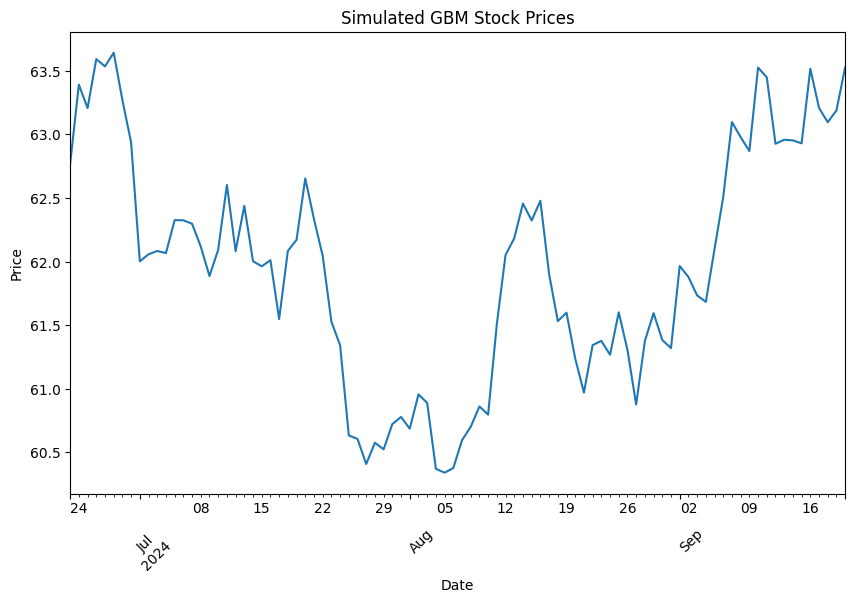

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
delta_hedge_df.price.plot()
plt.title('Simulated GBM Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

To simulate delta-heding, first determine for each time and price the delta. Given the dataframe already contains that information, it's needed only to include a delta column.

In [22]:
delta_hedge_df['delta'] = delta_put(delta_hedge_df['price'], K, delta_hedge_df['t'], sigma, rf, q)
delta_hedge_df.head()

,price,t,delta
2024-06-23,62.770000,0.247222,-0.390788
2024-06-24,63.391087,0.244444,-0.324088
2024-06-25,63.206332,0.241667,-0.343458
2024-06-26,63.591991,0.238889,-0.303121
2024-06-27,63.534683,0.236111,-0.308742


In this case, I'm writing a put. Money is earned from the sale. But then delta-hedging the position by buying the underlying stock will also represent a cost.

In [23]:
contract_size = 100

stock_prices = np.array(delta_hedge_df.price[:N])
deltas = np.array(delta_hedge_df.delta[:N])
option_prices, stocks_purchased, stocks_held = np.zeros(N), np.zeros(N), np.zeros(N)
stock_values, options_purchased, options_held = np.zeros(N), np.zeros(N), np.zeros(N)
options_value, interest_earned, cash_positions = np.zeros(N), np.zeros(N), np.zeros(N)
portfolio_values = np.zeros(N)

option_prices[0], stocks_purchased[0], stocks_held[0] = put_bsm_price, deltas[0] * contract_size, deltas[0] * contract_size
stock_values[0], options_purchased[0], options_held[0] = stocks_held[0] * S0, -1, -1
options_value[0] = options_held[0] * option_prices[0]
cash_positions[0] = - stocks_purchased[0] * S0 - options_purchased[0] * option_prices[0]
portfolio_values[0] = cash_positions[0] + options_value[0] + stock_values[0]

columns = ['Step', 'S', 'T', 'Option Price','Options purchased', 'Options Held', 'Options Value',
           'Delta', 'Stocks Purchased', 'Stocks Held', 'Stock Value',
           'Cash Value', 'interest', 'Portfolio Value']
results_df = pd.DataFrame(columns=columns)
results_df.loc[0] = [0, S0, T, option_prices[0], options_purchased[0], options_held[0], options_value[0],
                     deltas[0], stocks_purchased[0], stocks_held[0], stock_values[0],
                     cash_positions[0], 0, portfolio_values[0]]
results_df.head()


,Step,S,T,Option Price,Options purchased,Options Held,Options Value,Delta,Stocks Purchased,Stocks Held,Stock Value,Cash Value,interest,Portfolio Value
0,0.0,62.77,0.247222,0.982919,-1.0,-1.0,-0.982919,-0.390788,-39.078849,-39.078849,-2452.979334,2453.962253,0.0,0.0


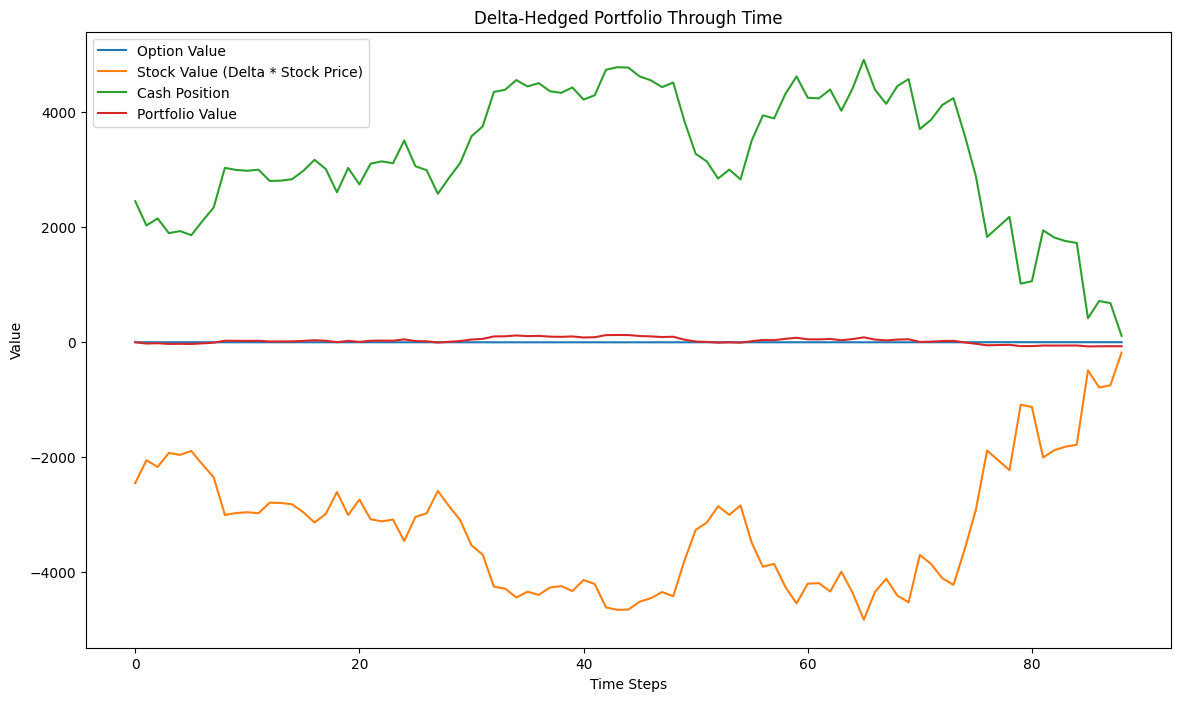

In [24]:
for i in range(1, N):
    S = stock_prices[i]
    T_i = T - i * T/N
    option_prices[i] = bsm_put(S, K, T_i, sigma, rf, q)
    
    stocks_purchased[i] = deltas[i] * contract_size - stocks_held[i-1]
    stocks_held[i] = stocks_held[i - 1] + stocks_purchased[i]
    stock_values[i] = stocks_held[i] * S
    
    options_purchased[i] = 0
    options_held[i] = options_held[i-1] + options_purchased[i]
    options_value[i] = options_held[i] * option_prices[i]
    
    interest_earned[i] = cash_positions[i - 1] * np.exp(rf*T/N) - cash_positions[i-1]
    cash_positions[i] = cash_positions[i - 1] + interest_earned[i] - stocks_purchased[i] * S
    
    portfolio_values[i] = cash_positions[i] + stock_values[i] + options_value[i]

results_df = pd.DataFrame({
    'Step': np.arange(N),
    'S': stock_prices,
    'T': T - np.arange(N) * T/N,
    'Option Price': option_prices,
    'Options Purchased': options_purchased,
    'Options Held': options_held,
    'Options Value': options_value,
    'Delta': deltas,
    'Stocks Purchased': stocks_purchased,
    'Stocks Held': stocks_held,
    'Stock Value': stock_values,
    'Cash Value': cash_positions,
    'Interest Earned': interest_earned,
    'Portfolio Value': portfolio_values,
})

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(options_value, label='Option Value')
plt.plot(stock_values, label='Stock Value (Delta * Stock Price)')
plt.plot(cash_positions, label='Cash Position')
plt.plot(portfolio_values, label='Portfolio Value')
plt.title('Delta-Hedged Portfolio Through Time')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

## 3) Estimate the fair value of the call & put option contracts using Monte Carlo (MC) simulation methods considering 50000 simulations

To estimate the fair values of the call & put option contracts using Monte Carlo (MC) simulation, we need to take in consideration two things:
- We're dealing with a dividend paying stock
- This an American Option contract, so it can be exercised before maturity

This means that our simulation will have to:
- On dividend paying days, discount price at time t by dividend
- On each point estimate if exercising the option at time t generates more value than holding it to t+1

The last point can be achieved through the Least-Squares Monte Carlo Algorithm (LSM) of Longstaff-Schwartz (2001), using the a regression estimator to determine if it's better to exercise it at that point in time.
We can then tweak the code to compute the day, and if it matches a dividend paying day, discount the stock price.

To improve accuracy, we can use antithetic variates.

----------------------

First, we need to generate dividend paying dates. We don't know when the stock is going to pay dividends, but knowing it's usual frequency we can grab the last dividend date and simulate from there:

In [25]:
def get_dividend_dates(ticker: yf.Ticker, frequency_months: int, starting_date: datetime, ending_date: datetime):
    """
    Generates array of possible future dividend dates
    ticker - yf.Ticker object of stock
    frequency_months - how many months per year dividend is paid
    starting_date - when it starts (dividend dates cannot be before this)
    ending_date - when it ends (dividend dates cannot be after this)
    """
    dividend_history = ticker.dividends
    if dividend_history.empty: return []
    
    #get last dividend
    last_dividend_date = dividend_history.index[-1].tz_localize(None) 
    dividend_frequency = pd.DateOffset(months=frequency_months)
    
    #generate future dividends
    future_dividend_dates = []
    next_dividend_date = last_dividend_date + dividend_frequency
    
    #generate future dividend dates until the ending_date
    while next_dividend_date <= ending_date:
        if next_dividend_date >= starting_date:
            future_dividend_dates.append(next_dividend_date)
        next_dividend_date += dividend_frequency
    
    return future_dividend_dates
    
dividend_dates = get_dividend_dates(ticker=ticker, frequency_months=4, starting_date=today_date, ending_date=closest_date_dt_obj)
dividend_dates

[]

In our case, there's no dividends in contract...

In [26]:
def monte_carlo_option_pricing_with_dividends(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call = True):
    dt = T/steps #time in years by steps
    df = np.exp(-r * dt) #discounting factor
    
    #set initial values (matrix & initial values)
    S = np.zeros((steps+1, runs))
    S[0, :] = S0
    
    #current date for dividend payoff
    current_date = starting_date
    
    #simulate prices
    for t in range(1, steps + 1):
        #draw random value
        ran = np.random.standard_normal(int(runs / 2))
        #antithetic variates
        ran = np.concatenate((ran, -ran))
        #correct first & second moments, respectively
        ran = ran - np.mean(ran)
        ran = ran / np.std(ran)
        #the gbm formula (average * dt + sigma * sqrt(dt))
        nudt = (r - 0.5 * sigma**2) * dt
        sdt = sigma * np.sqrt(dt) * ran
        S[t, :] = S[t-1, :] * np.exp(nudt + sdt)
        #if dividend date, discount dividend yield
        for div_date in div_dates:
            if current_date.date() == div_date.date():
                S[t, :] = S[t, :] * np.exp(-q*dt)
                break
        #increment current date
        current_date = current_date + timedelta(days=1)
        #if saturday or sunday, add 2 or 1 - respectively
        if current_date.weekday() == 5:
            current_date = current_date + timedelta(days=2)
        elif current_date.weekday() == 6:
            current_date = current_date + timedelta(days=1)
    
    #compute payoff
    p = np.maximum(S - K, 0) if is_call else np.maximum(K - S, 0)
    #value matrix of payoffs
    V = np.zeros_like(p)
    V[-1] = p[-1]
    
    #Use LSM to compute exercise decision (backwards in time)
    for t in range(steps-1, 0, -1):
        #fit regression of stock prices to discounted payoffs
        reg = np.polyfit(S[t, :], V[t+1, :] * df, 5)
        #determine regression (future) payoffs starting at this point
        reg_val = np.polyval(reg, S[t, :])
        #compute best values given regression
        V[t, :] = np.where(p[t, :] > reg_val, p[t, :], V[t+1, :] * df)
    
    #return actual LSM estimator value (average value of discounted payoffs by simulations)
    return np.sum(V[1, :] * df) / runs

### a) Compare price results with those obtained using the Black-Scholes formula. Compare both to actual market results.

We can now apply it to our Monte Carlo simulation with 50000 simulations to check it against BSM and market values, doing a step for each day of the tenor of the contract...

In [27]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

call_mc_price = monte_carlo_option_pricing_with_dividends(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=50000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=True)
print("Call MC price:", call_mc_price)
put_mc_price = monte_carlo_option_pricing_with_dividends(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=50000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=False)
print("Put MC price:", put_mc_price)
print("------------------------------")
print("Call BSM price:", call_bsm_price)
print("Put BSM price:", put_bsm_price)
print("------------------------------")
print("Market call price:", closest_call.lastPrice)
print("Market put price:", closest_put.lastPrice)

Call MC price: 1.9113515023324463
Put MC price: 0.9416319099533971
------------------------------
Call BSM price: 1.8229190731457834
Put BSM price: 0.9829190731457906
------------------------------
Market call price: 2.24
Market put price: 1.4


### b) Estimate the Greeks (e.g., delta, gamma, theta, ....) using MC simulation for both contracts. 

To estimate the greeks, using a Monte Carlo simulation, we can use the formulas:

- Delta = Change in option value / Change in underlying value
- Gamma = C(S+ΔS,K,T,σ,r)−2C(S,K,T,σ,r)+C(S−ΔS,K,T,σ,r)/(ΔS)^2
- Vega = Change in value / Change in volatility
- Theta = Change in value / Change in time
- Rho = Change in value / Change in interest rates

In [45]:
def monte_carlo_option_delta(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call=True):
    epsilon_price = 1e-2 * S0
    return (monte_carlo_option_pricing_with_dividends(S0 + epsilon_price, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call) -
            monte_carlo_option_pricing_with_dividends(S0 - epsilon_price, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call)) / (2 * epsilon_price)

def monte_carlo_option_gamma(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call=True):
    epsilon_price = 1e-2 * S0
    return (monte_carlo_option_pricing_with_dividends(S0 + epsilon_price, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call) -
            2 * monte_carlo_option_pricing_with_dividends(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call) +
            monte_carlo_option_pricing_with_dividends(S0 - epsilon_price, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call)) / (epsilon_price**2)

def monte_carlo_option_vega(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call=True):
    #calculate option price at current volatility
    price_current = monte_carlo_option_pricing_with_dividends(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call)
    #calculate option price after small volatility perturbation
    price_perturbed = monte_carlo_option_pricing_with_dividends(S0, K, T, r, sigma + 0.01, runs, steps, div_dates, q, starting_date, is_call)
    #calculate Vega
    return (price_perturbed - price_current) / 0.01

def monte_carlo_option_theta(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call=True):
    #normal price    
    price_current = monte_carlo_option_pricing_with_dividends(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call)
    #spiked price
    price_perturbed = monte_carlo_option_pricing_with_dividends(S0, K, T - 1/365, r, sigma, runs, steps, div_dates, q, starting_date, is_call)
    # Calculate Theta
    theta = (price_current - price_perturbed) / (1/365)
    return theta * -1 if theta > 0 else theta

def monte_carlo_option_rho(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call=True):
    #calculate option price at current risk-free rate
    price_current = monte_carlo_option_pricing_with_dividends(S0, K, T, r, sigma, runs, steps, div_dates, q, starting_date, is_call)
    #calculate option price after small risk-free rate perturbation
    price_perturbed = monte_carlo_option_pricing_with_dividends(S0, K, T, r + 0.01, sigma, runs, steps, div_dates, q, starting_date, is_call)
    #calculate Rho
    return (price_perturbed - price_current) / 0.01

In [48]:
print("Delta Call MC:", monte_carlo_option_delta(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=True))
print("Gamma Call MC:", monte_carlo_option_gamma(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=True))
print("Theta Call MC:", monte_carlo_option_theta(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=True))
print("Vega Call MC:", monte_carlo_option_vega(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=True))
print("Rho Call MC:", monte_carlo_option_rho(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=True))
print("-----------------------------------------------------------")
print("Delta Put MC:", monte_carlo_option_delta(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=False))
print("Gamma Put MC:", monte_carlo_option_gamma(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=False))
print("Theta Put MC:", monte_carlo_option_theta(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=False))
print("Vega Put MC:", monte_carlo_option_vega(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=False))
print("Rho Put MC:", monte_carlo_option_rho(S0=S0, K=K, T=T, r=rf, sigma=sigma, runs=100000, steps=N, div_dates=dividend_dates, q=q, starting_date=today_date, is_call=False))

Delta Call MC: 0.6343087137502577
Gamma Call MC: 0.09387112238011033
Theta Call MC: -5.387341358532158
Vega Call MC: 11.006845447532498
Rho Call MC: 7.726150801937681
-----------------------------------------------------------
Delta Put MC: -0.3985253609511769
Gamma Put MC: 0.14165066663554066
Theta Put MC: -3.501271495994731
Vega Put MC: 11.238818188802357
Rho Put MC: -4.710191136379827


We can now compare against the BSM greeks:

In [30]:
greeks_df

,call,put
delta,0.604999,-0.391185
gamma,0.110382,0.110382
theta,-3.971527,-1.710759
vega,12.018963,12.018963
rho,9.036408,-6.386203
